In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

import scipy
from scipy import ndimage


In [2]:
# Parameters
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [3]:
base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_shape=(img_size, img_size, 3))

# Freeze base layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [4]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=10
)


Epoch 1/10
 26/189 [===>..........................] - ETA: 3:41 - loss: 0.5811 - accuracy: 0.6887

C:\Users\Hp\anaconda3\envs\dlc\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


189/189 [==============================] - 267s 1s/step - loss: 0.2356 - accuracy: 0.9052 - val_loss: 0.0876 - val_accuracy: 0.9742
Epoch 2/10
189/189 [==============================] - 266s 1s/step - loss: 0.0766 - accuracy: 0.9745 - val_loss: 0.0673 - val_accuracy: 0.9775
Epoch 3/10
189/189 [==============================] - 262s 1s/step - loss: 0.0633 - accuracy: 0.9788 - val_loss: 0.0540 - val_accuracy: 0.9841
Epoch 4/10
189/189 [==============================] - 255s 1s/step - loss: 0.0501 - accuracy: 0.9830 - val_loss: 0.0469 - val_accuracy: 0.9848
Epoch 5/10
189/189 [==============================] - 260s 1s/step - loss: 0.0461 - accuracy: 0.9851 - val_loss: 0.0523 - val_accuracy: 0.9848
Epoch 6/10
189/189 [==============================] - 261s 1s/step - loss: 0.0395 - accuracy: 0.9873 - val_loss: 0.0531 - val_accuracy: 0.9841
Epoch 7/10
189/189 [==============================] - 256s 1s/step - loss: 0.0361 - accuracy: 0.9873 - val_loss: 0.0484 - val_accuracy: 0.9808
Epoch 8/10

In [5]:
model.save("my_model.h5")



In [6]:
from tensorflow.keras.models import load_model

model = load_model("my_model.h5")

loss, acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {acc*100:.2f}%")


48/48 [==============================] - 50s 1s/step - loss: 0.0644 - accuracy: 0.9815
Validation Accuracy: 98.15%


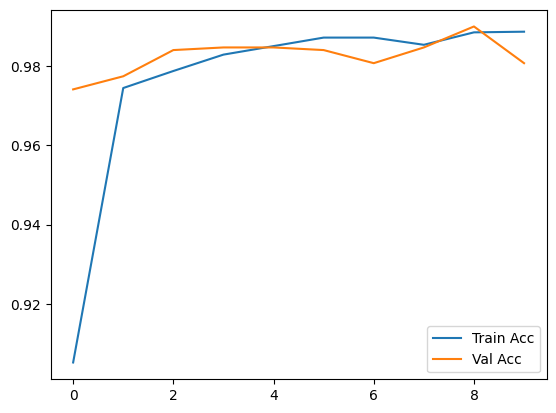

In [7]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def predict_mask(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    if pred < 0.5:
        print(f"{img_path}: Mask Detected 😷")
    else:
        print(f"{img_path}: No Mask Detected 😐")
    # Show image with label
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
    plt.show()

    print(f"{img_path}: {label}")    


test_with_mask_dir = "dataset/test/with_mask"
test_without_mask_dir = "dataset/test/without_mask"


if os.path.exists(test_with_mask_dir) and os.listdir(test_with_mask_dir):
    first_with_mask_img = os.path.join(test_with_mask_dir, os.listdir(test_with_mask_dir)[0])
    predict_mask(first_with_mask_img)
else:
    print(f"No images found in {test_with_mask_dir}")

if os.path.exists(test_without_mask_dir) and os.listdir(test_without_mask_dir):
    first_without_mask_img = os.path.join(test_without_mask_dir, os.listdir(test_without_mask_dir)[1])
    predict_mask(first_without_mask_img)
else:
    print(f"No images found in {test_without_mask_dir}")

1/1 [==============================] - 1s 1s/step
dataset/test/with_mask\with_mask_1.jpg: Mask Detected 😷
1/1 [==============================] - 0s 73ms/step
dataset/test/without_mask\without_mask_10.jpg: No Mask Detected 😐


In [9]:
import cv2

cap = cv2.VideoCapture(0)  # Webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    face = cv2.resize(frame, (img_size, img_size))
    face = np.expand_dims(face/255.0, axis=0)
    pred = model.predict(face)[0][0]

    label = "Mask 😷" if pred < 0.5 else "No Mask 😐"
    color = (0,255,0) if pred < 0.5 else (0,0,255)

    cv2.putText(frame, label, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.imshow("Mask Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 94ms/step
